## Visual Geometry Group Models (VGG16 & VGG19)
Documentation to be filled up later BLABLABLA

### Installation and Import Checks

In [18]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline
%pip install keras_tuner
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: tensorflow==2.10 in c:\users\matthew chuang\documents\github\csc3009-brain-tumor-detection\dependencies\lib\site-packages (2.10.0)




[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt
import seaborn as sns
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [20]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. 

In [21]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is output hot coded
y_output = to_categorical(y_output, num_classes=4)
# Resizes images to 224 x 224 for optimal size for VGG models
x_input_resized = np.array([tf.image.resize(image, (224, 224)).numpy() for image in x_input])

Splits for training and testing 80/20 ratio

In [22]:
# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input_resized, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 224x224x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Optional: Hyperparameter Optimisation
For the most optimal parameters for the VGG Models, 


For hyperparameter optimisation, the team experimented with the keras tuner on the base VGG model VGG16. We created a function that iterates through different models builds trying out different number of neurons, dropout and learning rates to see which works best for the model, which will be used as the most optimal parameters for our trained model subsequently. 

In [23]:
# # Function to build the model
# def build_model(hp):
#     base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
#     for layer in base_vgg16_model.layers:
#         layer.trainable = False

#     x = base_vgg16_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
    
#     # Tune the number of units in the first dense layer
#     units_1 = hp.Int('units_1', min_value=512, max_value=1024, step=128)
#     x = Dense(units_1, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
#     x = Dropout(dropout_1)(x)
    
#     # Tune the number of units in the second dense layer
#     units_2 = hp.Int('units_2', min_value=256, max_value=512, step=128)
#     x = Dense(units_2, activation='relu', kernel_constraint=max_norm(3))(x)
    
#     # Tune the dropout rate
#     dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
#     x = Dropout(dropout_2)(x)
    
#     new_output_layer_vgg16 = Dense(4, activation='softmax')(x)  # 4 classes: no tumor, glioma, meningioma, pituitary
    
#     model = Model(inputs=base_vgg16_model.input, outputs=new_output_layer_vgg16)
    
#     # Tune the learning rate
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

In [24]:
# # Set up the tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=30,
#     executions_per_trial=1,
#     directory='kt_tuner_vggtest'
#     project_name='brain_tumor_classification'
# )

# # Define callbacks
# checkpoint = ModelCheckpoint('model_checkpoints/vgg16_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# # Run the hyperparameter search
# tuner.search(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), callbacks=[checkpoint, early_stopping])

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
# The optimal dropout rate for the first dropout layer is {best_hps.get('dropout_1')}.
# The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
# The optimal dropout rate for the second dropout layer is {best_hps.get('dropout_2')}.
# The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

### Define VGG Models
In this segment, pretrained VGG models are called from TensorFlow. These models are configured to receive its weightages trained from the ImageNet dataset and to receive a 224x224x3 image input. The top layer is also removed for further improvements. 
* weights='imagenet' > Loads weightages from ImageNet data training
* include_top = False > Exclude top layers of model, to add custom top layers (tuning with our data)
* input_shape > Specify the dimensions of our input data, which is given as 224 x 224 pixels and 3 representing color channels in each image (RGB)



#### Defining Model VGG16

In [35]:
# Load the VGG16 model pre-trained on ImageNet
base_vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In place of the last layer that was dropped, new layers are defined to fine tune the base model to our use case. These layers will have their weights altered based on the data we train it on. For other model layers, they are frozen to prevent any amendments to weightage. 

Resources for Layering Operations:
* How Global Average Pooling works: https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=with%20nine%20elements.-,What%20is%20GlobalAveragePooling2D()%20in%20Keras%3F,an%20operation%20on%20the%20data.
* How Batch Normalisation works: https://arxiv.org/abs/1502.03167
* How kernal constraints works: https://keras.io/api/layers/constraints/#:~:text=MaxNorm%20class&text=Constrains%20the%20weights%20incident%20to,max_norm%20.
* How dropout layers works: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout#:~:text=The%20Dropout%20layer%20randomly%20sets,over%20all%20inputs%20is%20unchanged.


In [36]:
# Adds average pool layer to reduce dimensionality of feature maps
new_layers_vgg16 = GlobalAveragePooling2D()(base_vgg16_model.output)
# Adds a normalisation layer to enhance performance with bigger batch sizes (32)
new_layers_vgg16 = BatchNormalization()(new_layers_vgg16)
# Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg16 = Dense(1024, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# Add first dropout layer with 20% dropout rate to avoid overfitting   
new_layers_vgg16 = Dropout(0.2)(new_layers_vgg16)
# Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg16 = Dense(384, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg16)
# Add second dropout layer with 20% dropout rate to avoid overfitting  
new_layers_vgg16 = Dropout(0.2)(new_layers_vgg16)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_vgg16 = Dense(4, activation='softmax')(new_layers_vgg16)

# Define the model
vgg16_model = Model(inputs=base_vgg16_model.input, outputs=output_layer_vgg16)

# Freeze the layers of the base model
for layer in base_vgg16_model.layers:
    layer.trainable = False

#### Defining Model VGG19

In [27]:
# Load the VGG19 model pre-trained on ImageNet 
base_vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [28]:
# Adds average pool layer to reduce dimensionality of feature maps
new_layers_vgg19 = GlobalAveragePooling2D()(base_vgg19_model.output)
# Adds a normalisation layer to enhance performance with bigger batch sizes (32)
new_layers_vgg19 = BatchNormalization()(new_layers_vgg19)
# Add first dense layer of 1024 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(1024, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add first dropout layer with 20% dropout rate to avoid overfitting   
new_layers_vgg19 = Dropout(0.2)(new_layers_vgg19)
# Add second dense layer of 384 neurons with RELU, adds weight constraints, regularising weights directly
new_layers_vgg19 = Dense(384, activation='relu', kernel_constraint=max_norm(3))(new_layers_vgg19)
# Add second dropout layer with 20% dropout rate to avoid overfitting  
new_layers_vgg19 = Dropout(0.2)(new_layers_vgg19)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_vgg19 = Dense(4, activation='softmax')(new_layers_vgg19)

# Define the model
vgg19_model = Model(inputs=base_vgg19_model.input, outputs=output_layer_vgg19)

# Freeze the layers of the base model
for layer in base_vgg19_model.layers:
    layer.trainable = False

### Training the VGG Models
In this segment, the models were configured to be compiled using the
* Adam's Optimizer
* Categorical Cross Entropy for Multi-Class Classification
* Accuracy

Checkpoints were defined to save best models based on validation loss. 

#### Training Model VGG16

In [37]:
# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_vgg16 = ModelCheckpoint('model_checkpoints/vgg16_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg16 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
vgg16_history = vgg16_model.fit(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg16, early_stopping_vgg16])

Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7331
Epoch 1: val_loss improved from inf to 1.12329, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 4s 79ms/step - loss: 0.6678 - accuracy: 0.7331 - val_loss: 1.1233 - val_accuracy: 0.5521
Epoch 2/25
48/48 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9089
Epoch 2: val_loss improved from 1.12329 to 0.87610, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 4s 80ms/step - loss: 0.2583 - accuracy: 0.9089 - val_loss: 0.8761 - val_accuracy: 0.6432
Epoch 3/25
48/48 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9538
Epoch 3: val_loss improved from 0.87610 to 0.84049, saving model to model_checkpoints\vgg16_brain_tumor.keras
48/48 [==============================] - 4s 79ms/step - loss: 0.1316 - accuracy: 0.9538 - val_loss: 0.8405 - val_accuracy: 0.6589
Ep

#### Training Model VGG19

In [30]:
# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_vgg19 = ModelCheckpoint('/model_checkpoints/vgg19_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
vgg19_history = vgg19_model.fit(x_input_train, y_output_train, epochs=25, validation_data=(x_input_test, y_output_test), 
                    callbacks=[checkpoint_vgg19, early_stopping_vgg19])

Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.7240
Epoch 1: val_loss improved from inf to 1.26143, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 5s 87ms/step - loss: 0.7234 - accuracy: 0.7240 - val_loss: 1.2614 - val_accuracy: 0.4609
Epoch 2/25
48/48 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.8750
Epoch 2: val_loss improved from 1.26143 to 1.17593, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 4s 84ms/step - loss: 0.3565 - accuracy: 0.8750 - val_loss: 1.1759 - val_accuracy: 0.4505
Epoch 3/25
48/48 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9186
Epoch 3: val_loss improved from 1.17593 to 0.94117, saving model to /model_checkpoints\vgg19_brain_tumor.keras
48/48 [==============================] - 4s 83ms/step - loss: 0.2280 - accuracy: 0.9186 - val_loss: 0.9412 - val_accuracy: 0.5807

### Evaluation using Simple Metrics & Classification Metrics
Simple model metrics to be plotted over the use of matplotlib plots
* Loss metrics for training and validation
* Overall accuracy for training and validation

More detailed breakdown of how the model's prediction compare to actual labels using a 4x4 Confusion Matrix, each dimension representing the class to be predicted. From it will derive three more metrics such as
* Precision Metric
* Recall Metric
* F1 Score

In [31]:
def plot_simple_metrics(history, title):
    """ Plot training and validation loss and accuracy. """
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Fix the accuracy scale from 0 to 1
    plt.yticks([i/10.0 for i in range(11)])  # Set y-ticks to show labels at intervals of 0.1
    plt.legend()

    plt.suptitle(title)
    plt.show()

def plot_confusion_matrix(model):
    """ Evaluate a trained model on test data and display the confusion matrix and classification report. """
    # Class labels
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # Predict the labels for the test data
    predictions = model.predict(x_input_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_output_test, axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print the classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:")
    print(report)

#### Simple & Classification Metrics for Model VGG16

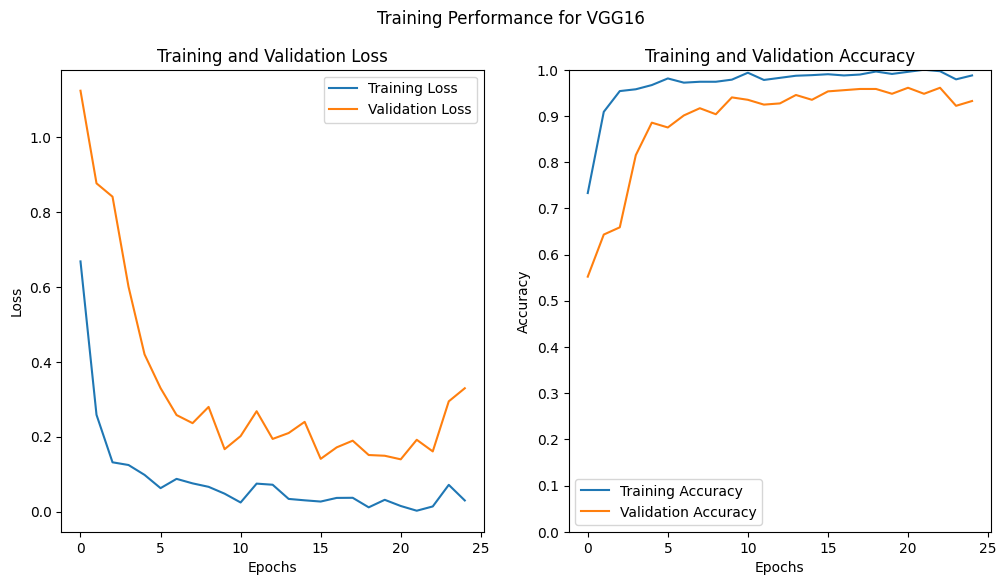

12/12 [==============================] - 1s 63ms/step


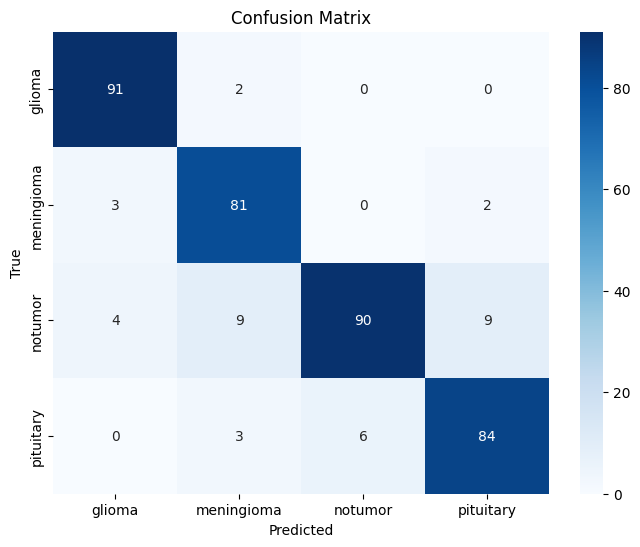

Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.98      0.95        93
  meningioma       0.85      0.94      0.90        86
     notumor       0.94      0.80      0.87       112
   pituitary       0.88      0.90      0.89        93

    accuracy                           0.90       384
   macro avg       0.90      0.91      0.90       384
weighted avg       0.90      0.90      0.90       384



In [38]:
plot_simple_metrics(vgg16_history, "Training Performance for VGG16")
plot_confusion_matrix(vgg19_model)

#### Simple & Classification Metrics for Model VGG19

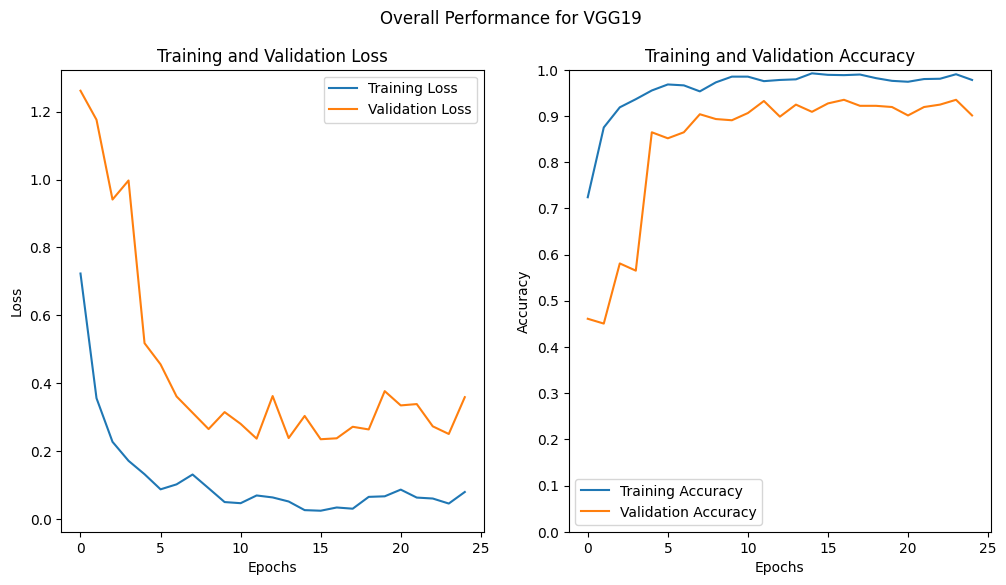

12/12 [==============================] - 1s 63ms/step


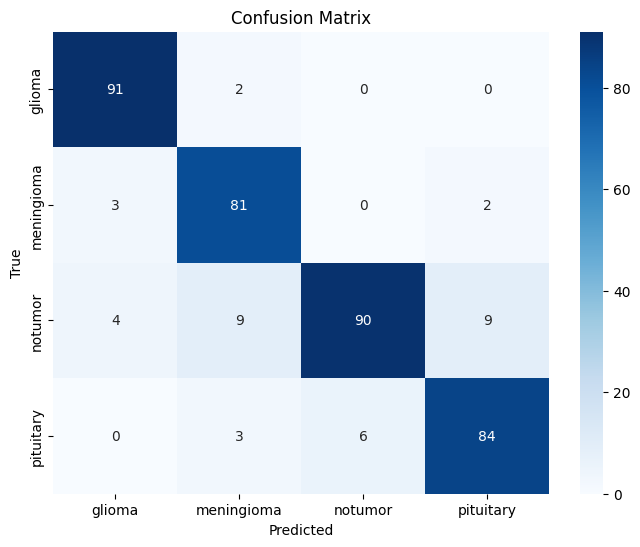

Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.98      0.95        93
  meningioma       0.85      0.94      0.90        86
     notumor       0.94      0.80      0.87       112
   pituitary       0.88      0.90      0.89        93

    accuracy                           0.90       384
   macro avg       0.90      0.91      0.90       384
weighted avg       0.90      0.90      0.90       384



In [33]:
plot_simple_metrics(vgg19_history, "Overall Performance for VGG19")
plot_confusion_matrix(vgg19_model)